In [1]:
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO)

import os.path

import ipytest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

In [2]:
import sklearn.model_selection as sk_model_selection

from python_speech_features import mfcc

from chmp.ds import mpl_set
from chmp.label import listdata
from chmp.torch_utils.model import Model

from chmp.app.kwdetect.model import (
    KeywordModel, 
    batch_transform_xy,
    batch_transform_x,
    transform_y,
    n_features,
)
from chmp.app.kwdetect.segmentation import compute_speechiness
from chmp.app.kwdetect.util import (
    label_decoding, 
    label_encoding, 
    load_sample, 
)

In [3]:
data = listdata('./data/*.ogg')

In [4]:
labeled_data = [d for d in data if d['label'] in label_encoding]
labels = [d["label"] for d in labeled_data]

train_idx, test_idx = sk_model_selection.train_test_split(
    np.arange(len(labeled_data)), test_size=0.15, stratify=labels,
)

data_train = [labeled_data[i] for i in train_idx]
data_test = [labeled_data[i] for i in test_idx]

In [5]:
print(f'Number of train examples {len(data_train)}, number of test examples {len(data_test)}')

Number of train examples 864, number of test examples 153


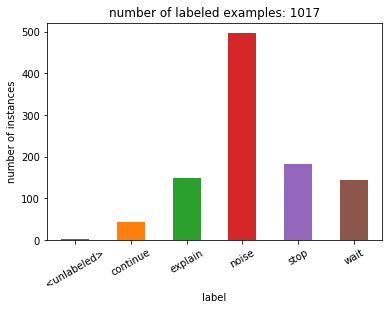

In [6]:
df = pd.DataFrame(data)

df.groupby('label').size().sort_index().plot.bar(rot=30)
plt.ylabel('number of instances')
plt.title(f'number of labeled examples: {(df["label"] != "<unlabeled>").sum()}')
pass

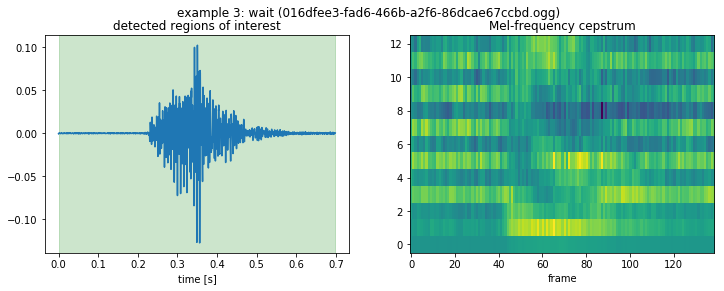

In [7]:
def _plot(idx=0, data=data):
    samplerate = 44100
    
    sample = load_sample(data[idx]['file'])    
    in_speech, blocks = compute_speechiness(sample, samplerate=samplerate, in_speech=False)
    
    time = np.arange(len(sample)) / samplerate
    features = mfcc(sample, 44100, winlen=10e-3, winstep=5e-3, numcep=13)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(time[::10], sample[::10])
    
    for block in blocks:
        plt.axvspan(time[np.min(block)], time[np.max(block)], alpha=0.2, color='g')
    
    plt.title(f'detected regions of interest')
    plt.xlabel('time [s]')
    
    plt.subplot(1, 2, 2)
    plt.imshow(features.T, aspect='auto', interpolation='none', origin='lower')
    plt.title('Mel-frequency cepstrum')
    plt.xlabel('frame')
    
    plt.suptitle(f'example {idx}: {data[idx]["label"]} ({os.path.basename(data[idx]["file"])})')
    
    plt.show()
    
_plot(3)

# Model

In [8]:
def accuracy(logits, labels):
    _, indices = logits.max(dim=1)
    return (labels == indices).type(torch.float).mean()

In [9]:
n_classes = len(label_encoding)

model = Model(
    module=KeywordModel(n_features, n_classes),
    loss=torch.nn.CrossEntropyLoss(),
)

history = model.fit_transformed(
    batch_transform_xy,
    data_train if not ipytest.running_as_test() else data_train[:200],
    batch_transform=True,
    epochs=20 if not ipytest.running_as_test() else 1, 
    verbose=True,
    validation_data=data_test,
    metrics=[F.cross_entropy, accuracy],
    dtype=None,
)

torch.save(model, "./run/model/model.pth")

[done. took 22m 46s] 0.0443 cross_entropy: 0.356 accuracy: 0.895 (19 / 20)                                              



In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(ax1)
plt.plot(history.get('epoch'), history.get('loss'), label='train')
plt.plot(history.get('epoch'), history.get(('metrics', 'cross_entropy')), label='validation')
mpl_set(xlabel='Epoch', ylabel='Loss', legend=True)

plt.sca(ax2)
plt.plot(history.get('epoch'), history.get(('metrics', 'accuracy')), label='validation')
mpl_set(xlabel='Epoch', ylabel='Accuracy', legend=True)

In [ ]:
pred = model.predict_transformed(batch_transform_x, data_test, batch_transform=True)

In [ ]:
y_test = np.asarray([transform_y(d) for d in data_test])

In [ ]:
confusion_matrix, *_ = np.histogram2d(
    y_test, 
    np.argmax(pred, axis=1),
    bins=(np.arange(n_classes + 1) - 0.5, np.arange(n_classes + 1) - 0.5),
)
confusion_matrix = np.asarray(confusion_matrix, dtype=np.int64)

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
mpl_set(
    xlabel="predicted",
    ylabel="truth",
    title='{:.1%} accuracy'.format(np.diag(confusion_matrix).sum() / confusion_matrix.sum()),
    xticks=(np.arange(n_classes) + 0.5,  [label_decoding[i] for i in np.arange(n_classes)]),
    yticks=(np.arange(n_classes) + 0.5,  [label_decoding[i] for i in np.arange(n_classes)]),
    invert="y",
)